In [27]:
#pip install en_core_web_sm

In [28]:
#pip install pyvis

In [29]:
#pip install spacy

In [30]:
#!python -m spacy download en_core_web_sm

In [4]:
import spacy
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
ELM = spacy.load('en_core_web_sm')

In [6]:
print(ELM)

# Used functions

In [18]:
# Filter entities that exist in the character dataframe
def filter_entity(ent_list,character_df):
    return[ent for ent in ent_list
           if ent in list(character_df.Characters)
           or ent in list(character_df.Firstname)
           or ent in list(character_df.Nickname)
           or ent in list(character_df.Nickname2)]

# Load the document and data

In [8]:
text = open(file= 'data/jane-austen-pride-prejudice.txt').read()
doc_texto = ELM(text)

In [14]:
data_characters = pd.read_excel('data/characters.xlsx')
data_characters.head()

,Characters,Firstname,Nickname,Nickname2,real_name
0,Mr. Bennet,Mr. Bennet,Bennet,NaN,Mr. Bennet/Mrs.Bennet
1,Mrs. Bennet,Mrs. Bennet,Bennet,NaN,Mr. Bennet/Mrs.Bennet
2,Jane Bennet,Jane,NaN,NaN,Jane Bennet
3,Miss Elizabeth Bennet,Elizabeth,Eliza,Lizzy,Elizabeth
4,Mary Bennet,Mary,NaN,NaN,Mary Bennet


In [15]:
#Let’s take a look at the document
spacy.displacy.render(doc_texto[0:150],style = "ent",jupyter = True)

Let's get started, first of all, we're gonna have to build a pandas dataframe with our sentences and use the NLP model to recognize entities.

In [16]:
# Split all the sentences and entities into a dataframe
sent_entity_df = []
for i in doc_texto.sents:
    entiti_list = [i.text for i in i.ents]
    sent_entity_df.append({"sentence": i , "entities": entiti_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [17]:
sent_entity_df

,sentence,entities
0,"(﻿CHAPTER, I., \n\n)",[﻿CHAPTER I.\n\n]
1,"(It, is, a, truth, universally, acknowledged, ...",[]
2,"(However, little, known, the, feelings, or, vi...","[first, some one]"
3,"("", My, dear, Mr., Bennet, ,, "", said, his, la...","[Bennet, Netherfield Park]"
4,"("", \n\n, Mr., Bennet, replied, that, he, had,...",[Bennet]
...,...,...
5545,"(By, Elizabeth, 's, instructions, she, began, ...","[Elizabeth, more than ten years]"
5546,"(Lady, Catherine, was, extremely, indignant, o...","[Lady Catherine, Elizabeth]"
5547,"(But, at, length, ,, by, Elizabeth, 's, persua...","[Elizabeth, Pemberley]"
5548,"(With, the, Gardiners, ,, they, were, always, ...",[]


In [19]:
#Let's try the function
filter_entity(["Lady Catherine","Thu","2"],data_characters)

['Lady Catherine']

In [20]:
# Using the function to extract the characters in the sentence
sent_entity_df['characters_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x,data_characters))
# Make a dataframe with the characters entities only
sent_entity_df_filtered = sent_entity_df[sent_entity_df['characters_entities'].map(len)> 0]

In [21]:
sent_entity_df_filtered.head(15)

,sentence,entities,characters_entities
3,"("", My, dear, Mr., Bennet, ,, "", said, his, la...","[Bennet, Netherfield Park]",[Bennet]
4,"("", \n\n, Mr., Bennet, replied, that, he, had,...",[Bennet],[Bennet]
5,"("", But, it, is, ,, "", returned, she, ;, "", fo...",[Long],[Long]
6,"("", \n\n, Mr., Bennet, made, no, answer, ., \n\n)",[Bennet],[Bennet]
10,"("", Why, ,, my, dear, ,, you, must, know, ,, M...","[Long, Netherfield, England, Monday, four, Mor...","[Long, Morris]"
11,"("", \n\n, "", What, is, his, name, ?, "", \n\n, ...",[Bingley],[Bingley]
16,"("", \n\n, "", My, dear, Mr., Bennet, ,, "", repl...",[Bennet],[Bennet]
22,"(You, and, the, girls, may, go, ,, or, you, ma...",[Bingley],[Bingley]
27,"("", \n\n, "", But, ,, my, dear, ,, you, must, i...",[Bingley],[Bingley]
31,"(Sir, William, and, Lady, Lucas, are, determin...","[William, Lady Lucas]","[William, Lady Lucas]"


## Now we're gonna get all of these characters entities that we found and calculate the relationship between them

In [ ]:
window_size = 5 # iterate 5 setences
relationships = [] # Initializes an empty list of relationships.

# Starts a for loop iterating the indices of the dataframe
for i in range(sent_entity_df_filtered.index[-1]): 
    # Ensures that the ending index does not exceed the dataframe size
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    # Sums all the characters found within a range of rows defined by end_i
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].characters_entities), []) 
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [ ]:
relation_df = pd.DataFrame(relationships)

In [ ]:
relation_df.head(5)

,source,target
0,Long,Morris
1,Long,Morris
2,Morris,Bingley
3,Long,Morris
4,Morris,Bingley


In [ ]:
relation_df["value"] = 1
relationship_df = relation_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [ ]:
relationship_df.head(10)

,source,target,value
0,Long,Morris,6
1,Morris,Bingley,5
2,Bingley,William,5
3,William,Lady Lucas,18
4,Lady Lucas,Bingley,3
5,Bingley,Lizzy,53
6,Lizzy,Jane,42
7,Jane,Lydia,67
8,Lydia,Lizzy,16
9,Lizzy,Bingley,31


In [ ]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

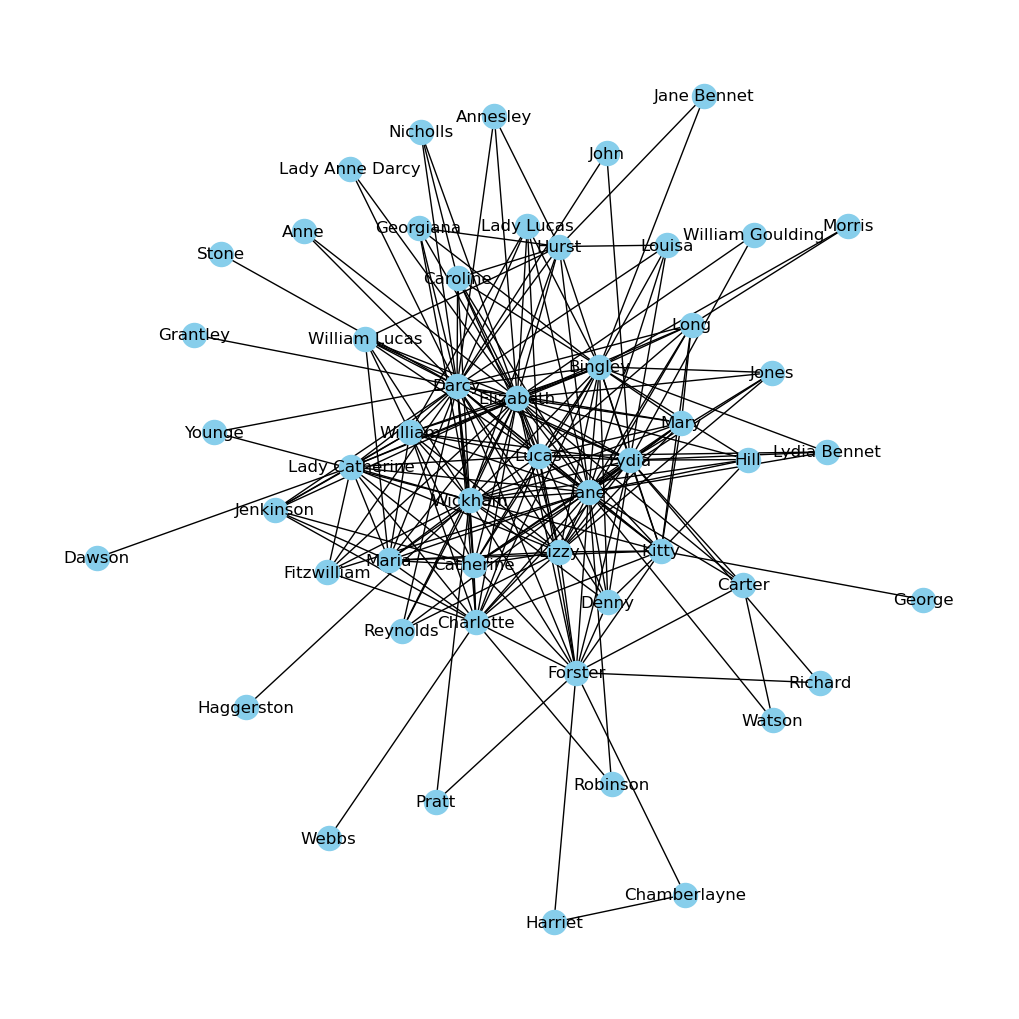

In [ ]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
from pyvis.network import Network
net = Network(notebook=True, width="1000px",height="700px",bgcolor='#222222',font_color= "white")
net.from_nx(G)
net.show('Pride_and_prejudice.html')

Pride_and_prejudice.html


In [ ]:
from pyvis.network import Network
sources = relationship_df['source']
targets = relationship_df['target']
weights = relationship_df['value']
got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
got_net.barnes_hut()

edge_data = zip(sources, targets, weights)

for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]

                got_net.add_node(src, src, title=src)
                got_net.add_node(dst, dst, title=dst)
                got_net.add_edge(src, dst, value=w)

neighbor_map = got_net.get_adj_list()

# add neighbor data to node hover data
for node in got_net.nodes:
                node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
                node["value"] = len(neighbor_map[node["id"]])

#got_net.show("pride.html")

In [ ]:
got_net.show("pride.html")

pride.html


AttributeError: 'NoneType' object has no attribute 'render'